In [134]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import time

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
import joblib

from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import RandomizedSearchCV

# from catboost import Pool, cv, CatBoostClassifier, CatBoostRegressor

In [135]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [238]:
av = pd.read_csv('/content/drive/MyDrive/final_project_msc/data/av_blackfriday/data_set_blackfriday_pred/train.csv')
iris = pd.read_csv('/content/drive/MyDrive/final_project_msc/data/iris/IRIS.csv')
titanic = pd.read_csv('/content/drive/MyDrive/final_project_msc/data/titanic/train.csv')
print('train_set\n')
av.head()
print('test_set \n')
iris.head()
print('submission \n')
titanic.head()

train_set



,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


test_set 



,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


submission 



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [137]:
print(av.columns)
print(iris.columns)
print(titanic.columns)

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')
Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [138]:
av.info()
print('av\n')
av.info()
print('iris \n')
iris.info()
print('titanic \n')
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB
av

<class 'pa

# First find the categorical/numerical and id, target columns
* Remove the id columns or check on them and find wheather they can be changed 
* 


In [139]:
# for col in av.columns:
#   print(col)

In [239]:
id_cols = []
target_cols = []
cat_cols_obj = []
num_cols_all = []
# num_cols_cont = []
# num_cols_cat = []
num_cols_skewed = []
num_cols_cor = []
num_cols_norm = []
num_cols_norm_outliers = []
num_cols_skewed_outliers = []

# these have only the good ones but null available features are also available
num_cols_skewed_done = []
num_cols_cor_done = []
num_cols_norm_done = []
num_cols_norm_outliers_done = []
num_cols_skewed_outliers_done = []

num_cols_skewed_null = []
num_cols_cor_null = []
num_cols_norm_null = []
num_cols_norm_outliers_null = []
num_cols_skewed_outliers_null = []
cat_cols_obj_null = []
num_cols_all_null = []
cat_cols_obj_null_to_del = []
num_cols_all_null_to_del = []

# these set is the final set as the nulls are filtered and done
num_cols_skewed_null_done = []
num_cols_cor_null_done = []
num_cols_norm_null_done = []
num_cols_norm_outliers_null_done = []
num_cols_skewed_outliers_null_done = []

In [240]:
def feat_types(df, target):
  start_time = time.clock()

  id_cols = []
  target_cols = []
  cat_cols_obj = []
  num_cols_all = []

#     identify the target column and remove in this function
  target_cols = [target]
  df_original = df.copy()

  
  df.drop([target], axis=1, inplace=True) # remove the target column from the dataset
  
#     do identify the target column and convert to num if categorical
  

#     identify the ids and remove the ids
  for col in df.columns:
      # print(col)
      perc_unique = df[col].nunique()/len(av[col])*100
      if perc_unique > 97.0: # get the ids 
        id_cols.append(col)
      elif df.dtypes[col] == 'object': # get the string cat features
        cat_cols_obj.append(col)
      else:
        num_cols_all.append(col) # get all the other int and float numericals 

  ''' this cat variable identification is kept as a feature engineering method in the other modules
      for col in num_cols_all():
        if 10 > df_copy.col.nunique() > 2:
          num_cols_cat.append(col)
        else:
          num_cols_cont.append(col)'''
      
# identify the cat cols in the numerical all columns in other words identify the discrete and continuous 
# num_cols_all = [i for i in df_copy.columns if i not in [target_col] and i not in id_cols and i not in cat_obj_cols]

  print(time.clock() - start_time, "seconds took to finish dtype identifier") 

  return df, id_cols, target_cols, cat_cols_obj, num_cols_all
  

In [241]:
df_av, id_cols_av, target_cols_av, cat_cols_obj_av, num_cols_all_av =feat_types(av, 'Purchase')

0.20939099999999655 seconds took to finish dtype identifier


In [242]:
# print('df_copy_av \n',df_copy_av)
print('id_cols_av \n', id_cols_av)
print('target_cols_av \n', target_cols_av)
print('cat_cols_obj_av \n', cat_cols_obj_av)
print('num_cols_all_av \n', num_cols_all_av)

id_cols_av 
 []
target_cols_av 
 ['Purchase']
cat_cols_obj_av 
 ['Product_ID', 'Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']
num_cols_all_av 
 ['User_ID', 'Occupation', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']


In [243]:
df_av.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN


# Highly corelated feature identification removal

In [244]:
df_av.corr()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
User_ID,1.000000,-0.023971,0.020443,0.003825,0.001529,0.003419
Occupation,-0.023971,1.000000,0.024280,-0.007618,-0.000384,0.013263
Marital_Status,0.020443,0.024280,1.000000,0.019888,0.015138,0.019473
Product_Category_1,0.003825,-0.007618,0.019888,1.000000,0.540583,0.229678
Product_Category_2,0.001529,-0.000384,0.015138,0.540583,1.000000,0.543649
Product_Category_3,0.003419,0.013263,0.019473,0.229678,0.543649,1.000000


In [245]:
# in here null values are not to be considered

def cor_identifier(df, num_cols_all):
  threshold = 0.9
# get the corelations morethan 0.5
  cormat= df.corr()
  #get the most corelated features
  feature =[]
  value = []

  for col in num_cols_all:
    corrdata= cormat[col]
    for i, index in enumerate(corrdata.index):
        if abs(corrdata[index]) > threshold:
            feature.append(index)
            value.append(corrdata[index])
    df_corr = pd.DataFrame(data= value, index= feature, columns=['corr_value'])
      
  return df_corr




  # def get_corr_features(corrdata, threshold):
  #     feature = []
  #     value = []
  #     for i, index in enumerate(corrdata.index):
  #         if abs(corrdata[index]) > threshold:
  #             feature.append(index)
  #             value.append(corrdata[index])
  #     df = pd.DataFrame(data= value, index= feature, columns=['corr_value'])
      
  #     return df


# corr_df = cor_identifier(av,num_cols_all_av)
# corr_df

In [246]:
corr_df = cor_identifier(df_av, num_cols_all_av)
corr_df

,corr_value
User_ID,1.0
Occupation,1.0
Marital_Status,1.0
Product_Category_1,1.0
Product_Category_2,1.0
Product_Category_3,1.0


# Skewed continuous feature identification and treatment



*   Important Notes:

· If the skewness is between -0.5 and 0.5, the data are fairly symmetrical

· If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed

· If the skewness is less than -1 or greater than 1, the data are highly skewed
Here is the syntax to show the skewness value

pd.DataFrame(exam.skew(),columns=[‘skewness’])

or

dataFrame.skew(axis=1)




In [224]:
# skewed_num_cols = []
# df_skew = av.skew(axis=0, skipna=True)
# print(df_skew)
# print(df_skew[1])
# # df_skew = pd.DataFrame(data= value, index= feature, columns=['corr_value'])


# #     feature = []
# #     value = []
# #     for i, index in enumerate(corrdata.index):
# #         if abs(corrdata[index]) > threshold:
# #             feature.append(index)
# #             value.append(corrdata[index])
# #     df = pd.DataFrame(data= value, index= feature, columns=['corr_value'])
      

In [177]:
# cat_cols_obj_av = []
# num_cols_all_av = []
# id_cols_av = []
# target_cols_av = []
# id_cols = []
# target_cols = []
# cat_cols_obj = []
# num_cols_all = []

# av = pd.read_csv('/content/drive/MyDrive/final_project_msc/data/av_blackfriday/data_set_blackfriday_pred/train.csv')
# df_av, id_cols_av, target_cols_av, cat_cols_obj_av, num_cols_all_av =feat_types(av, 'Purchase')

In [247]:
print(cat_cols_obj_av)
print(num_cols_all_av)

['Product_ID', 'Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']
['User_ID', 'Occupation', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']


In [172]:
df_av.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN


In [248]:
def skew_identifier(df):
  start_time = time.clock()
  num_cols_skewed = []
  num_cols_norm = []
  df_skew = df.skew(axis =0, skipna=True)
  for col in df_skew.index:
    if abs(df_skew[col]) >1:
      num_cols_skewed.append(col)
    else:
      num_cols_norm.append(col)
  print(time.clock() - start_time, "seconds took to finish skew identifier")
  return num_cols_skewed, num_cols_norm

In [183]:
num_cols_skewed_av = []
num_cols_norm_av = []
# num_cols_skewed = []
# num_cols_norm = []

In [249]:
num_cols_skewed_av, num_cols_norm_av = skew_identifier(df_av)

0.14598900000000015 seconds took to finish skew identifier


In [ ]:
# av['Product_Category_3_log'] = np.log(av['Product_Category_3']+1)

In [ ]:
# av.isnull().sum()

In [250]:
print(num_cols_skewed_av)
print(num_cols_norm_av)

['Product_Category_1']
['User_ID', 'Occupation', 'Marital_Status', 'Product_Category_2', 'Product_Category_3']


In [159]:
'''def skewd_convo_test(df, num_cols_norm_av):
  for col in num_cols_norm_av:
    av = df_av.copy()
    av[col+'_log'] = np.log(av[col]+1)

  for col in num_cols_norm_av:
    av = df_av.copy()
    av[col+'_sqrt'] = av[col]**1/2
  # av['Prod_cat_3_num_cols_skewed_log'] = np.log(av['Product_Category_3']+1)
  return av'''

In [251]:
from scipy.stats import boxcox

def skew_fix(df, num_cols_skewed, num_cols_norm):
  start_time = time.clock()
  num_cols_skewed_done = []

  # ln transformation
  for col in num_cols_skewed:
    new_col = str(col) + '_num_cols_skewed_log'
    df[new_col] = np.log(df[col] + 1)
    # add new colum to the new done list
    num_cols_skewed_done.append(new_col)
    print(df.head())
  # squar root transformation 
  for col in num_cols_skewed:
    new_col = str(col) + '_num_cols_skewed_sqr'
    df[new_col] = df[col]**(1/2)
    num_cols_skewed_done.append(new_col)
    print(df.head())
  
  num_cols_norm = num_cols_norm + num_cols_skewed_done

  # boxcox transformation
  # for col in num_cols_skewed:
  #   df[str(col)+'_num_cols_skewd'+'_boxcox'] = boxcox(df[col], lambda = None)
  # df = pd.DataFrame()
  print(time.clock() - start_time, "seconds took to finish skew fix")
  return df, num_cols_skewed_done, num_cols_norm

In [252]:
df_av, num_cols_skewed_done_av, num_cols_norm_av = skew_fix(df_av,num_cols_skewed_av, num_cols_norm_av )
df_av.head()

   User_ID  ... Product_Category_1_num_cols_skewed_log
0  1000001  ...  1.386294                             
1  1000001  ...  0.693147                             
2  1000001  ...  2.564949                             
3  1000001  ...  2.564949                             
4  1000002  ...  2.197225                             

[5 rows x 12 columns]
   User_ID  ... Product_Category_1_num_cols_skewed_sqr
0  1000001  ...  1.732051                             
1  1000001  ...  1.000000                             
2  1000001  ...  3.464102                             
3  1000001  ...  3.464102                             
4  1000002  ...  2.828427                             

[5 rows x 13 columns]
0.11021000000000925 seconds took to finish skew fix


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Product_Category_1_num_cols_skewed_log,Product_Category_1_num_cols_skewed_sqr
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,1.386294,1.732051
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,0.693147,1.000000
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,2.564949,3.464102
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,2.564949,3.464102
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,2.197225,2.828427


In [253]:
print(num_cols_norm_av)
print(num_cols_skewed_done_av)


['User_ID', 'Occupation', 'Marital_Status', 'Product_Category_2', 'Product_Category_3', 'Product_Category_1_num_cols_skewed_log', 'Product_Category_1_num_cols_skewed_sqr']
['Product_Category_1_num_cols_skewed_log', 'Product_Category_1_num_cols_skewed_sqr']


# Identify the Outliers and keep or filter



*   How to treat outliers?
👉 Trimming: It excludes the outlier values from our analysis. By applying this technique our data becomes thin when there are more outliers present in the dataset. Its main advantage is its fastest nature.

👉Capping: In this technique, we cap our outliers data and make the limit i.e, above a particular value or less than that value, all the values will be considered as outliers, and the number of outliers in the dataset gives that capping number.

For Example, if you’re working on the income feature, you might find that people above a certain income level behave in the same way as those with a lower income. In this case, you can cap the income value at a level that keeps that intact and accordingly treat the outliers.

👉Treat outliers as a missing value: By assuming outliers as the missing observations, treat them accordingly i.e, same as those of missing values.

You can refer to the missing value article 

👉 Discretization: In this technique, by making the groups we include the outliers in a particular group and force them to behave in the same manner as those of other points in that group. This technique is also known as Binning.


**Identifying the outliers**


👉  The data points which fall below mean-3*(sigma) or above mean+3*(sigma) are outliers.


👉 For Skewed distributions: Use Inter-Quartile Range (IQR) proximity rule.

– The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers.

where Q1 and Q3 are the 25th and 75th percentile of the dataset respectively, and IQR represents the inter-quartile range and given by Q3 – Q1.

Interquartile Range (IQR) to Detect Outliers

This article was published as a part of the Data Science Blogathon 

Introduction
In my previous article, I talk about the theoretical concepts about outliers and trying to find the answer to the question: “When we have to drop outliers and when to keep outliers?”.

To gain a better understanding of this article, firstly you have to read that  and then proceed with this so that you have a clear idea about the outlier analysis in Data Science Projects.

In this article, we will try to give the answer to the following questions along with the Python implementation,

👉 How to treat outliers?

👉 How to detect outliers?

👉 What are the techniques for outlier detection and removal?

 

Let’s get started

How to treat outliers?
👉 Trimming: It excludes the outlier values from our analysis. By applying this technique our data becomes thin when there are more outliers present in the dataset. Its main advantage is its fastest nature.

👉Capping: In this technique, we cap our outliers data and make the limit i.e, above a particular value or less than that value, all the values will be considered as outliers, and the number of outliers in the dataset gives that capping number.

For Example, if you’re working on the income feature, you might find that people above a certain income level behave in the same way as those with a lower income. In this case, you can cap the income value at a level that keeps that intact and accordingly treat the outliers.

👉Treat outliers as a missing value: By assuming outliers as the missing observations, treat them accordingly i.e, same as those of missing values.

You can refer to the missing value article 

👉 Discretization: In this technique, by making the groups we include the outliers in a particular group and force them to behave in the same manner as those of other points in that group. This technique is also known as Binning.

You can learn more about discretization .

How to detect outliers?

👉 For Normal distributions: Use empirical relations of Normal distribution.

– The data points which fall below mean-3*(sigma) or above mean+3*(sigma) are outliers.

where mean and sigma are the average value and standard deviation of a particular column.

Characteristics of a Normal Distribution

Fig. Characteristics of a Normal Distribution

Image Source: 

 

👉 For Skewed distributions: Use Inter-Quartile Range (IQR) proximity rule.

– The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers.

where Q1 and Q3 are the 25th and 75th percentile of the dataset respectively, and IQR represents the inter-quartile range and given by Q3 – Q1.

Interquartile Range (IQR) to Detect Outliers | Naysan Saran

Fig. IQR to detect outliers

Image Source: 

 

👉 For Other distributions: Use percentile-based approach.

For Example, Data points that are far from 99% percentile and less than 1 percentile are considered an outlier.



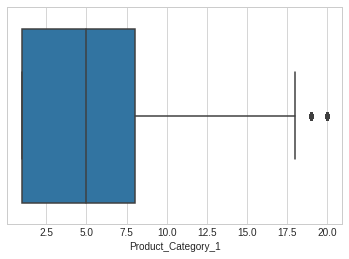

In [ ]:
sns.boxplot(av['Product_Category_1'])

In [ ]:
av.shape
109694

(550068, 12)

109694

In [ ]:
upper_limit_other =  av['Product_Category_1'].quantile(0.99)
lower_limit_other =  av['Product_Category_1'].quantile(0.01)
print(upper_limit_other)

q1 = av['Product_Category_1'].quantile(0.25)
q3 = av['Product_Category_1'].quantile(0.75)
iqr = q3-q1
upper_limit_skew = q1 + 1.5* iqr
lower_limit_skew = q1 - 1.5*iqr 
outliers_skew = len(av[av['Product_Category_1']> upper_limit_skew])  + len(av[av['Product_Category_1'] < lower_limit_skew])
print('skew', outliers_skew)

18.0
skew 34993


In [ ]:
# normal distributions
outliers_norm = av[av['Product_Category_1'] > av['Product_Category_1'].mean() + 3 * av['Product_Category_1'].std()]
print(len(outliers_norm))

# skewed distributions
q1 = av['Purchase'].quantile(0.25)
q3 = av['Purchase'].quantile(0.75)
iqr = q3-q1
upper_limit_skew = q1 + 1.5* iqr
lower_limit_skew = q1 - 1.5*iqr 
outliers_skew = len(av[av['Purchase']> upper_limit_skew])  + len(av[av['Purchase'] < lower_limit_skew])
print(outliers_skew)


# other distributions

upper_limit_other =  av['Purchase'].quantile(0.99)
lower_limit_other =  av['Purchase'].quantile(0.01)



7278
109694


# Outlier identification and fixing 
* seems like that can be possible as in this case only capping is done

In [254]:
def outlier_identifier_fix(df, num_cols_norm, num_cols_skewed):
  start_time = time.clock()

  num_cols_norm_outliers = []
  num_cols_skewed_outliers = []
  num_cols_norm_outliers_done = []
  num_cols_skewed_outliers_done = []
  # num_cols_skewed_done_outliers = [] skewed done means they are normal so add to the normal list
  # num_cols_skewed_done_outliers_done = []
  

# outliers which follow the normal distribution
  for col in num_cols_norm: 
    upper_limit_norm = df[col].mean() + 3*df[col].std()
    lower_limit_norm = df[col].mean() - 3*df[col].std()
    outliers_norm = df[df[col] > upper_limit_norm] + df[df[col] < lower_limit_norm]
    if len(outliers_norm) >= 1:
      num_cols_norm_outliers.append(col)
      # fixing the outliers norm   ----------------------------------------------------------- capping
      new_col = str(col)+'_num_cols_norm_outliers_cap'
      df[new_col] = np.where(df[col]>upper_limit_norm, upper_limit_norm,np.where(df[col]<lower_limit_norm,lower_limit_norm,df[col]))
      num_cols_norm_outliers_done.append(new_col)      


# outliers which are skewed 
  for col in num_cols_skewed:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    upper_limit_skew = q1 + 1.5* iqr
    lower_limit_skew = q1 - 1.5* iqr 
    outliers_skew = len(df[df[col]> upper_limit_skew])  + len(df[df[col] < lower_limit_skew])
    if outliers_skew >= 1:
      num_cols_skewed_outliers.append(col)
      # fixing the outliers skewed   -------------------------------------------------------------- capping
      new_col = str(col)+'_num_cols_skewed_outliers_cap'
      df[new_col] = np.where(df[col] > upper_limit_skew,upper_limit_skew,np.where(df[col] < lower_limit_skew,lower_limit_skew,df[col]))
      num_cols_skewed_outliers_done.append(new_col)
  

  num_cols_norm = num_cols_norm + num_cols_norm_outliers_done + num_cols_skewed_outliers_done 

  print(time.clock() - start_time, "seconds took to finish outlier identifier and fix")

  return df, num_cols_skewed_outliers, num_cols_norm_outliers, num_cols_norm_outliers_done, num_cols_skewed_outliers_done, num_cols_norm

In [255]:
df_av, num_cols_skewed_outliers_av, num_cols_norm_outliers_av, num_cols_norm_outliers_done_av, num_cols_skewed_done_av, num_cols_norm_av = outlier_identifier_fix(df_av, num_cols_norm_av, num_cols_skewed_av)

0.14160099999999431 seconds took to finish outlier identifier and fix


In [256]:
df_av.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Product_Category_1_num_cols_skewed_log,Product_Category_1_num_cols_skewed_sqr,Product_Category_1_num_cols_skewed_outliers_cap
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,1.386294,1.732051,3.0
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,0.693147,1.000000,1.0
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,2.564949,3.464102,11.5
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,2.564949,3.464102,11.5
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,2.197225,2.828427,8.0


In [259]:
print(num_cols_skewed_outliers_av)
print(num_cols_norm_outliers_av)
print(num_cols_norm_outliers_done_av)
print(num_cols_skewed_done_av)
print(num_cols_norm_av)
print(num_cols_skewed_done_av)

['Product_Category_1']
[]
[]
['Product_Category_1_num_cols_skewed_outliers_cap']
['User_ID', 'Occupation', 'Marital_Status', 'Product_Category_2', 'Product_Category_3', 'Product_Category_1_num_cols_skewed_log', 'Product_Category_1_num_cols_skewed_sqr', 'Product_Category_1_num_cols_skewed_outliers_cap']
['Product_Category_1_num_cols_skewed_outliers_cap']


In [ ]:
def outlier_fix(df, num_cols_skewed_outliers, num_cols_norm_outliers):
  # normal distribution outliers capping the outliers trimming is done at the end of the df as 2 dfs with different shapes
  # new_df = df[(df['cgpa'] < 8.80) & (df['cgpa'] > 5.11)]

  
  for col in num_cols_norm_outliers:
    # capping the outliers normal
    upper_limit_norm = df[col].mean() + 3*df[col].std()
    lower_limit_norm = df[col].mean() - 3*df[col].std()
    new_col = str(col)+'_num_cols_norm_outliers_cap'
    df[new_col] = np.where(df[col]>upper_limit_norm, upper_limit_norm,np.where(df[col]<lower_limit_norm,lower_limit_norm,df[col]))
    num_cols_norm_outliers_done.append(new_col)


    # trimming
    # df_trim = df[(df[col]>upper_limit_norm) & (df[col]< lower_limit_norm)]

  for col in num_cols_skewed_outliers:
    # capping the outliers skewed
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    upper_limit_skew = q1 + 1.5* iqr
    lower_limit_skew = q1 - 1.5* iqr 

    new_col = str(col)+'_num_cols_skewed_outliers_cap'
    df[str(col)+'_num_cols_skewed_outliers_cap'] = np.where(df[col] > upper_limit_skew,upper_limit_skew,np.where(df[col] < lower_limit_skew,lower_limit_skew,df[col]))
    num_cols_skewed_outliers_done.append(new_col)
    # trimming
    # df_trim = df[(df[col]>upper_limit_skew) & (df[col]< lower_limit_skew)]

  return df, num_cols_skewed_outliers_done, num_cols_norm_skewed_outliers_done





# Null columns identification and treatments

* every column should undergo with null identification 
* previous input is the columns which are identified as categorical numerical and with some other variations of those columsn
* filling the null values is done after skewed, outliers are capped or trimmed but it is good to keep the outliers in the list as some of the outliers maybe required for dataframes as it will symobolise all the items are taken considering the data preprocessing
* whatever the feature filling the null values or removing the unessary null values is a must
* for categoical features null value filling methods are differe from numerical features
* so filling null values should do categorical and numerical basis


**up to this point all the identifications for corelated and outliers are fixed in each case where cat and numerical**

In [ ]:
av.shape

(550068, 12)

In [ ]:
av['Product_Category_3'].isnull().sum()/av.shape[0]*100

69.67265865311198

In [ ]:
# at the end all the features which are null have different list regarding that speciality of the feature
# for egsample null columns which are normaly distributed are in 'num_cols_norm_null' where which are not null is in 'num_cols_norm'
# each and every feat considered null are removed from the previoustly available list

def null_identifier(df, num_cols_all,cat_cols_obj):
  start_time = time.clock()
  # null identify in the categorical columns with different types
  for col in cat_cols_obj:
    if df[col].isnull().sum()/df.shape[0] * 100 > 60:
      cat_cols_obj_null_to_del.append(col)
    elif df[col].isnull().sum()/df.shape[0] * 100 != 0:
      cat_cols_obj_null.append(col)

  # null identify in the numerical columns
  for col in num_cols_all:
    if df[col].isnull().sum()/df.shape[0] * 100 > 60:
      num_cols_all_null_to_del.append(col)
    elif df[col].isnull().sum()/df.shape[0] * 100 != 0:
      num_cols_all_null.append(col)

  # getting other columns filled 
  num_cols_cor_null = [i for i in num_cols_all_null if i in num_cols_cor]
  num_cols_norm_null = [i for i in num_cols_all_null if i in num_cols_norm]
  num_cols_skewed_null = [i for i in num_cols_all_null if i in num_cols_skewed]
  num_cols_norm_outliers_null = [i for i in num_cols_all_null if i in num_cols_norm_outliers]
  num_cols_skewed_outliers_null = [i for i in num_cols_all_null if i in num_cols_skewed_outliers]
  # num_cols_skewed_outliers_null = [i for i in num_cols_all_null if i in num_cols_skewed_outliers]
  # num_cols_skewed_null


  

  print(time.clock() - start_time, "seconds took to finish null identifier")

  return cat_cols_obj_null, num_cols_all_null, num_cols_cor_null, num_cols_skewed_null, num_cols_norm_outliers_null, num_cols_skewed_outliers_null, cat_cols_obj_null_to_del, num_cols_all_null_to_del
  # , num_cols_skewed_null, num_cols_norm_outliers_null, num_cols_skewed_outliers_null


In [ ]:
# cat_cols_obj_null_av, num_cols_all_null_av, num_cols_cor_null_av, num_cols_skewed_null_av, num_cols_norm_outliers_null_av, num_cols_skewed_outliers_null_av = null_identifier(av, num_cols_all_av, cat_cols_obj_av)
cat_cols_obj_null_av, num_cols_all_null_av, num_cols_cor_null_av, num_cols_skewed_null_av, num_cols_norm_outliers_null_av,num_cols_skewed_outliers_null_av = null_identifier(av, num_cols_all_av, cat_cols_obj_av)

print('cat_cols_obj_null_av: ',cat_cols_obj_null_av)
print('num_cols_all_null_av: ',num_cols_all_null_av)
print('num_cols_cor_null_av: ',num_cols_cor_null_av)
print('num_cols_skewed_null_av: ',num_cols_skewed_null_av)
print('num_cols_norm_outliers_null_av: ',num_cols_norm_outliers_null_av)
print('num_cols_skewed_outliers_null_av', num_cols_skewed_outliers_null_av)


# num_cols_all = [i for i in df_copy.columns if i not in [target_col] and i not in id_cols and i not in cat_obj_cols]


0.12516999999999712 seconds took to finish null identifier
cat_cols_obj_null_av:  []
num_cols_all_null_av:  ['Product_Category_3']
num_cols_cor_null_av:  []
num_cols_skewed_null_av:  []
num_cols_norm_outliers_null_av:  []
num_cols_skewed_outliers_null_av []


In [ ]:
# comb['Age_null'] = np.where(comb['Age'].isnull(), 1, 0)

# fixing the null features - all the features with null available needs to be fixed

* at this stage of the project all the other data pre processing is done except null values and cat encoding 
* num_cols_cor_fixed, num_cols_skewed_fixed, 

In [ ]:
av.isnull().sum()

User_ID                       0     
Product_ID                    0     
Gender                        0     
Age                           0     
Occupation                    0     
City_Category                 0     
Stay_In_Current_City_Years    0     
Marital_Status                0     
Product_Category_1            0     
Product_Category_2            173638
Product_Category_3            383247
Purchase                      0     
dtype: int64

In [ ]:
av['Product_Category_3'].mean()

12.668243206790512

In [ ]:
av['Product_Category_3'].max()

18.0

In [ ]:
def null_fix(df,cat_cols_obj_null_to_del, num_cols_all_null_to_del, cat_cols_obj_null,  num_cols_cor_null, num_cols_norm_null, num_cols_skewed_null, num_cols_norm_outliers_null, num_cols_skewed_outliers_null):
  # fill null with extreme values numerical
  # fill null with 'null' category 
  # make another column where null values are 0 and not null are 1
  # mean null filling numerical
  # median null filling numerical
  # mode null filling numerical
  # mode null filling categorical
  # filling null with feature combining krish method
  start_time = time.clock()

  # delete the features in the del list
  num_cat_cols_all_null_del = cat_cols_obj_null_to_del + num_cols_all_null_to_del
  df_null_not_del = df.copy()
  for col in num_cat_cols_all_null_del:
    df.drop([col], axis=1, inplace=True) # delete all the null delete columns


  # null filling in categorical features
  for col in cat_cols_obj_null:

    # create another feature wher null cols available
    new_col = str(col)+'cat_cols_obj_null_binary'
    df[new_col] = np.where(df[col].isnull(), 1,0)
    cat_cols_obj_null_done.append(new_col)

    # filling the null values with mode of the category
    new_col = str(col)+'cat_cols_obj_null_mode'
    df[new_col] = df[col].fillna(df[col].mode())
    cat_cols_obj_null_done.append(new_col)

    # filling the null values with another category of the category
    new_col = str(col)+'cat_cols_obj_null_extreme'
    df[new_col] = df[col].fillna('null')
    cat_cols_obj_null_done.append(new_col)


  # null filling in numerical features
  for col in num_cols_cor_null:
    # create another feature wher null cols available
    new_col = str(col)+'num_cols_cor_null_binary'
    df[new_col] = np.where(df[col].isnull(), 1,0)
    num_cols_cor_null_done.append(new_col)

    # filling the null values with mode of the category
    new_col = str(col)+'num_cols_cor_null_mode'
    df[new_col] = df[col].fillna(df[col].mode())
    num_cols_cor_null_done.append(new_col)

    # filling the null values with mean of the category
    new_col = str(col)+'num_cols_cor_null_mode'
    df[new_col] = df[col].fillna(df[col].mean())
    num_cols_cor_null_done.append(new_col)

    # filling the null values with mean of the category
    new_col = str(col)+'num_cols_cor_null_median'
    df[new_col] = df[col].fillna(df[col].median())
    num_cols_cor_null_done.append(new_col)

    # filling the null values with mean of the category
    new_col = str(col)+'num_cols_cor_null_extreme'
    max_val = df[col].max()
    df[new_col] = df[col].fillna(max_val+1000)
    num_cols_cor_null_done.append(new_col)
    


  for col in num_cols_norm_null:
    # create another feature wher null cols available
    new_col = str(col)+'num_cols_norm_null_binary'
    df[new_col] = np.where(df[col].isnull(), 1,0)
    num_cols_norm_null_done.append(new_col)

    # filling the null values with mode of the category
    new_col = str(col)+'num_cols_norm_null_mean'
    df[new_col] = df[col].fillna(df[col].mode())
    num_cols_norm_null_done.append(new_col)

    # filling the null values with mode of the category
    new_col = str(col)+'num_cols_norm_null_mode'
    df[new_col] = df[col].fillna(df[col].mean())
    num_cols_norm_null_done.append(new_col)

    # filling the null values with mode of the category
    new_col = str(col)+'num_cols_norm_null_median'
    df[new_col] = df[col].fillna(df[col].median())
    num_cols_norm_null_done.append(new_col)

    # filling the null values with mean of the category
    new_col = str(col)+'num_cols_cor_null_extreme'
    max_val = df[col].max()
    df[new_col] = df[col].fillna(max_val+1000)
    num_cols_norm_null_done.append(new_col)

  for col in num_cols_skewed_null:
    # create another feature wher null cols available
    new_col = str(col)+'num_cols_skewed_null_binary'
    df[new_col] = np.where(df[col].isnull(), 1,0)
    num_cols_skewed_null_done.append(new_col)

    # filling the null values with mode of the category
    new_col = str(col)+'num_cols_skewed_null_mode'
    df[new_col] = df[col].fillna(df[col].mode())
    num_cols_skewed_null_done.append(new_col)
 
    # filling the null values with mode of the category
    new_col = str(col)+'num_cols_skewed_null_mean'
    df[new_col] = df[col].fillna(df[col].mean())
    num_cols_skewed_null_done.append(new_col)
 
    # filling the null values with mode of the category
    new_col = str(col)+'num_cols_skewed_null_median'
    df[new_col] = df[col].fillna(df[col].median())
    num_cols_skewed_null_done.append(new_col)

    # filling the null values with mean of the category
    new_col = str(col)+'num_cols_cor_null_extreme'
    max_val = df[col].max()
    df[new_col] = df[col].fillna(max_val+1000)
    num_cols_skewed_null_done.append(new_col)

  for col in num_cols_skewed_outliers_null:
    # create another feature wher null cols available
    new_col = str(col)+'num_cols_skewed_outliers_null_binary'
    df[new_col] = np.where(df[col].isnull(), 1,0)
    num_cols_skewed_outliers_null_done.append(new_col)

    # filling the null values with mode of the category
    new_col = str(col)+'num_cols_skewed_outliers_null_mode'
    df[new_col] = df[col].fillna(df[col].mode())
    num_cols_skewed_outliers_null_done.append(new_col)

    # filling the null values with mode of the category
    new_col = str(col)+'num_cols_skewed_outliers_null_mean'
    df[new_col] = df[col].fillna(df[col].mean())
    num_cols_skewed_outliers_null_done.append(new_col)

    # filling the null values with mode of the category
    new_col = str(col)+'num_cols_skewed_outliers_null_median'
    df[new_col] = df[col].fillna(df[col].median())
    num_cols_skewed_outliers_null_done.append(new_col)

    # filling the null values with mean of the category
    new_col = str(col)+'num_cols_cor_null_extreme'
    max_val = df[col].max()
    df[new_col] = df[col].fillna(max_val+1000)
    num_cols_skewed_outliers_null_done.append(new_col)


  for col in num_cols_norm_outliers_null:
    # create another feature wher null cols available
    new_col = str(col)+'num_cols_norm_outliers_null_binary'
    df[new_col] = np.where(df[col].isnull(), 1,0)
    num_cols_norm_outliers_null_done.append(new_col)

    # filling the null values with mode of the category
    new_col = str(col)+'num_cols_norm_outliers_null_mode'
    df[new_col] = df[col].fillna(df[col].mode())
    num_cols_norm_outliers_null_done.append(new_col)

    # filling the null values with mode of the category
    new_col = str(col)+'num_cols_norm_outliers_null_mean'
    df[new_col] = df[col].fillna(df[col].mean())
    num_cols_norm_outliers_null_done.append(new_col)

    # filling the null values with mode of the category
    new_col = str(col)+'num_cols_norm_outliers_null_median'
    df[new_col] = df[col].fillna(df[col].median())
    num_cols_norm_outliers_null_done.append(new_col)

    # filling the null values with mean of the category
    new_col = str(col)+'num_cols_cor_null_extreme'
    max_val = df[col].max()
    df[new_col] = df[col].fillna(max_val+1000)
    num_cols_norm_outliers_null_done.append(new_col)


    # special null fix more customized methods to be continued in further final sets
    # new_col = str(col)+'num_cols_cor_null_special'
    # max_val = df[col].max()
    # df[new_col] = df[col].fillna(max_val+1000)

    # num_cols_norm_outliers_null_done.append(new_col)



# at the end of the null filling all the null columns needs to be removed which means only null_done lists are proceed as well as not null ones
  print(time.clock() - start_time, "seconds took to finish null fix")

  return df, cat_cols_obj_null_done,  num_cols_cor_null_done, num_cols_norm_outliers_null_done, num_cols_skewed_outliers_null_done, num_cols_skewed_null_done, num_cols_norm_null_done

# Categorical feature encoding various techniques

* all the encoded features are standardized with the name 
* feature_list_name_tech/solution-name
* One hot Encoding
* Dummy Encoding
*Effect Encoding
*Binary Encoding
*BaseN Encoding
*Hash Encoding
*Target Encoding

kinds of categorical data-

Ordinal Data: The categories have an inherent order- order is there where how many years person lived in a city

Nominal Data: The categories do not have an inherent order - no order cities where people live
 

import category_encoders as ce

**create object of Ordinalencoding**

encoder= ce.OrdinalEncoder(cols=['Degree'],return_df=True,                 mapping=[{'col':'Degree', 'mapping':{'None':0,'High school':1,'Diploma':2,'Bachelors':3,'Masters':4,'phd':5}}])

fit and transform train data 

df_train_transformed = encoder.fit_transform(train_df)

**Create object for one-hot encoding**

encoder=ce.OneHotEncoder(cols='City',handle_unknown='return_nan',return_df=True,use_cat_names=True)

Fit and transform Data

data_encoded = encoder.fit_transform(data)


encode the data

data_encoded=pd.get_dummies(data=data,drop_first=True)



Create object for hash encoder

encoder=ce.HashingEncoder(cols='Month',n_components=6)










*  in here the fixed cat cols encodes are not going to add to the dataframe they will be seperately kept in different lists and the previous categories are deleted
* these categorical variables after encoded kept as different dataframes where at the end they can be concat to main df sets
* data ordinal encoded features are added to the df




In [ ]:
from sklearn.preprocessing import LabelEncoder

def feat_encode(df, cat_cols_obj_null_done):

  # at the end of all the encoding we have to delete all the columns which are categorical obj

  for col in cat_cols_obj_null_done:

    # categorical encoding one hot encoding only if the nuniques < 16

    # label encoding for all as well as if > 16 in the above case
    new_col = str(col)+'cat_cols_obj_null_done_label'
    df[new_col] = LabelEncoder.fit_transorm(df[col])
    cat_cols_obj_null_done_label_done.append(new_col)
    





  pass

# Standardize the features